# Load data

In [1]:
import os
new_directory = '/dss/dsshome1/0D/ge74xuf2/climate_diffusion'
os.chdir(new_directory)
os.getcwd()

'/dss/dsshome1/0D/ge74xuf2/climate_diffusion'

In [2]:
%%capture
!pip install xarray
!pip install wandb
!pip install collections
!pip install pysteps
!pip install beartype
!pip install scikit-image
!pip install netcdf4
!pip install einx

In [3]:
from torch.utils import data
import matplotlib.pyplot as plt
import os
import json
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from src.utils import *
from src.utils_essential import *


from src.dataloader_sr import gfdl_eval_256, era5_upscaled_1d_256, era5_0_25d_256, qm_gfdl_trafo_units_hr
from src.dataloader_sr import QM_GFDL_LR_Dataset_256

Pysteps configuration file found at: /usr/local/lib/python3.10/dist-packages/pysteps/pystepsrc



In [4]:
bs_train = 10
bs_valid = 10


train_dataset = era5_0_25d_256(stage='train')
train_loader = data.DataLoader(train_dataset, batch_size=bs_train, shuffle=False, drop_last=True)
era5_hr_tr = next(iter(train_loader))
print("HR ERA5 train", era5_hr_tr.shape)


test_dataset = era5_0_25d_256(stage='valid')
test_loader = data.DataLoader(test_dataset, batch_size=bs_valid, shuffle=False, drop_last=True)
era5_hr_val = next(iter(test_loader))
print("HR ERA5 val", era5_hr_val.shape)

HR ERA5 train torch.Size([10, 1, 256, 256])
HR ERA5 val torch.Size([10, 1, 256, 256])


In [5]:
train_dataset_lr = era5_upscaled_1d_256(stage='train')
train_loader_lr = data.DataLoader(train_dataset_lr, batch_size=bs_train, shuffle=False, drop_last=True)
print("LR ERA5 train", next(iter(train_loader_lr)).shape)

test_dataset_lr = era5_upscaled_1d_256(stage='valid')
test_loader_lr = data.DataLoader(test_dataset_lr, batch_size=bs_valid, shuffle=False, drop_last=True)
print("LR ERA5 valid", next(iter(test_loader_lr)).shape)

LR ERA5 train torch.Size([10, 1, 256, 256])
LR ERA5 valid torch.Size([10, 1, 256, 256])


# init DM

In [6]:
import math
import copy
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import xarray as xr
import wandb
import IPython.display as display
import logging
import torch.nn.functional as F
import collections
import copy
import torchvision.transforms as transforms


from PIL import Image
from torch import optim
from PIL import Image
from torch.utils import data
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split
from inspect import isfunction
from functools import partial
from abc import abstractmethod
from skimage.metrics import structural_similarity as ssim
from pysteps.utils.spectral import rapsd, corrcoef
import matplotlib.ticker as ticker

from src.utils import *
from src.utils_essential import *
from src.base_network import BaseNetwork
from src.imagen_unet import *
from src.helper import *
from tqdm import tqdm

from src.dataloader_sr import gfdl_eval_256, era5_upscaled_1d_256, era5_0_25d_256, qm_gfdl_trafo_units_hr
from src.dataloader_sr import QM_GFDL_LR_Dataset_256

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
config = {"run_name": "revision_100",     
          "epochs":        400,
          "batch_size":    2, 
          "lr":            1e-5, 
          "image_size":    256,             
          "device":        "cuda", 
          "num_workers":   8, 
}

wandb.init(project='climate-diffusion', entity='Michi',config=config, save_code=True)
logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michi. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [8]:
class GaussianDiffusionContinuousTimes(BaseNetwork):
    def __init__(self, *, noise_schedule, timesteps = 1000,**kwargs):
        super(GaussianDiffusionContinuousTimes, self).__init__(**kwargs)
        
        if noise_schedule == "linear":
            self.log_snr = beta_linear_log_snr
        elif noise_schedule == "cosine":
            self.log_snr = alpha_cosine_log_snr
        else:
            raise ValueError(f'invalid noise schedule {noise_schedule}')

        self.num_timesteps = timesteps

    def get_times(self, batch_size, noise_level, *, device):
        return torch.full((batch_size,), noise_level, device = device, dtype = torch.float32)

    def sample_random_times(self, batch_size, *, device):
        return torch.zeros((batch_size,), device = device).float().uniform_(0, 1)

    def get_condition(self, times):
        return maybe(self.log_snr)(times)

    def get_sampling_timesteps(self, batch, *, device):
        times = torch.linspace(1., 0., self.num_timesteps + 1, device = device)
        times = repeat(times, 't -> b t', b = batch)
        times = torch.stack((times[:, :-1], times[:, 1:]), dim = 0)
        times = times.unbind(dim = -1)
        return times

    def q_posterior(self, x_start, x_t, t, *, t_next = None):
        t_next = default(t_next, lambda: (t - 1. / self.num_timesteps).clamp(min = 0.))

        """ https://openreview.net/attachment?id=2LdBqxc1Yv&name=supplementary_material """
        log_snr = self.log_snr(t)
        log_snr_next = self.log_snr(t_next)
        log_snr, log_snr_next = map(partial(right_pad_dims_to, x_t), (log_snr, log_snr_next))

        alpha, sigma = log_snr_to_alpha_sigma(log_snr)
        alpha_next, sigma_next = log_snr_to_alpha_sigma(log_snr_next)

        # c - as defined near eq 33
        c = -expm1(log_snr - log_snr_next)
        posterior_mean = alpha_next * (x_t * (1 - c) / alpha + c * x_start)
        
        # following (eq. 33)
        posterior_variance = (sigma_next ** 2) * c
        posterior_log_variance_clipped = log(posterior_variance, eps = 1e-20)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def q_sample(self, x_start, t, noise = None):
        dtype = x_start.dtype

        if isinstance(t, float):
            batch = x_start.shape[0]
            t = torch.full((batch,), t, device = x_start.device, dtype = dtype)

        noise = default(noise, lambda: torch.randn_like(x_start))
        log_snr = self.log_snr(t).type(dtype)
        log_snr_padded_dim = right_pad_dims_to(x_start, log_snr)
        alpha, sigma =  log_snr_to_alpha_sigma(log_snr_padded_dim)

        return alpha * x_start + sigma * noise, log_snr, alpha, sigma

    def q_sample_from_to(self, x_from, from_t, to_t, noise = None):
        shape, device, dtype = x_from.shape, x_from.device, x_from.dtype
        batch = shape[0]

        if isinstance(from_t, float):
            from_t = torch.full((batch,), from_t, device = device, dtype = dtype)

        if isinstance(to_t, float):
            to_t = torch.full((batch,), to_t, device = device, dtype = dtype)

        noise = default(noise, lambda: torch.randn_like(x_from))

        log_snr = self.log_snr(from_t)
        log_snr_padded_dim = right_pad_dims_to(x_from, log_snr)
        alpha, sigma = log_snr_to_alpha_sigma(log_snr_padded_dim)

        log_snr_to = self.log_snr(to_t)
        log_snr_padded_dim_to = right_pad_dims_to(x_from, log_snr_to)
        alpha_to, sigma_to = log_snr_to_alpha_sigma(log_snr_padded_dim_to)

        return x_from * (alpha_to / alpha) + noise * (sigma_to * alpha - sigma * alpha_to) / alpha

    def predict_start_from_v(self, x_t, t, v):
        log_snr = self.log_snr(t)
        log_snr = right_pad_dims_to(x_t, log_snr)
        alpha, sigma = log_snr_to_alpha_sigma(log_snr)
        return alpha * x_t - sigma * v

    def predict_start_from_noise(self, x_t, t, noise):
        log_snr = self.log_snr(t)
        log_snr = right_pad_dims_to(x_t, log_snr)
        alpha, sigma = log_snr_to_alpha_sigma(log_snr)
        return (x_t - sigma * noise) / alpha.clamp(min = 1e-8)

In [9]:
class EMA():
    def __init__(self, beta=0.9999):
        super().__init__()
        self.beta = beta
    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)
    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new


class BaseModel():
    def __init__(self, phase,  dataloader, metrics, n_epochs=10, batch_size = 8, 
                  save_checkpoint_epoch=10,resume_state=False,
                 save_path_base="/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion", **kwargs):
        """ init model with basic input, which are from __init__(**kwargs) function in inherited class """
        self.phase = phase
        self.device = "cuda"
        
        self.n_epochs = n_epochs
        self.resume_state = resume_state
        self.save_checkpoint_epoch = save_checkpoint_epoch

        ''' optimizers and schedulers '''
        self.schedulers = []
        self.optimizers = []

        ''' process record '''
        self.batch_size = batch_size
        self.epoch = 0
        self.iter = 0 

        self.phase_loader = dataloader
        self.metrics = metrics

        ''' logger to log file, which only work on GPU 0. writer to tensorboard and result file '''
        self.results_dict = CustomResult([],[])
        
        self.save_path_base = save_path_base

    
   
    def train(self):
        while self.epoch <= self.n_epochs: 
            self.epoch += 1
            
            train_log, condition_after_unet, original_img = self.train_step()
            
            print("epoch:", self.epoch)
            
            if self.epoch % 1 == 0:
                output_sampled = imagen.restoration(start_image_or_video=condition_after_unet.to(config["device"]))
                
                output_sampled_test = wandb.Image(output_sampled)
                wandb.log({"diffusion gen img": output_sampled_test})
                condition_after_unet_wb = wandb.Image(condition_after_unet)
                wandb.log({"condition img": condition_after_unet_wb})
                original_img_wb = wandb.Image(original_img)
                wandb.log({"original img": original_img_wb})
                
                print("proxy-ERA5")
                plot_images_no_lab(condition_after_unet)
                print("SR proxy-ERA5")
                plot_images_no_lab(output_sampled)
                print("ERA5")
                plot_images_no_lab(original_img)
                
                
                print("BLUE: ORIGINAL DATA VS ORANGE: DIFFUSION MODEL GENERATED")
                latitudinal_mean_three(original=original_img, generated=output_sampled, 
                                       label=condition_after_unet.detach() , var="p")
                print("BLUE: ORIGINAL DATA VS ORANGE: DIFFUSION MODEL GENERATED, GREEN: UNET GENERATED")
                histograms_three(original=original_img.detach(), generated=output_sampled.detach(),
                                 label= condition_after_unet.detach(),xlim_end=None, var="p")
                
                
                ssd = SpatialSpectralDensity_diff_res( 
                                      original_img.detach().cpu().numpy()
                                     ,output_sampled.detach().cpu().numpy()
                                     ,condition_after_unet.detach().cpu().numpy()
                                     ,new_labels = ["era5 hr"," sr era5","era5 lr"])
                ssd.run(num_times=None)
                ssd.plot_psd(fname="",model_resolution=0.25,model_resolution_2=0.25)
                
                plt.show()
                  
                    
            if self.epoch % self.save_checkpoint_epoch == 0:
                print('Saving the self at the end of epoch {:.0f}'.format(self.epoch))
                self.save_everything()

    def test(self):
        pass

    @abstractmethod
    def train_step(self):
        raise NotImplementedError('You must specify how to train your networks.')


    def test_step(self):
        pass
    
    def print_network(self, network):
        """ print network structure, only work on GPU 0 """
        if isinstance(network, nn.DataParallel) or isinstance(network, nn.parallel.DistributedDataParallel):
            network = network.module
        
        s, n = str(network), sum(map(lambda x: x.numel(), network.parameters()))
        net_struc_str = '{}'.format(network.__class__.__name__)
        print('Network structure: {}, with parameters: {:,d}'.format(net_struc_str, n))
        print(s)

    def save_network(self, network, network_label):
        """ save network structure, only work on GPU 0 """
        save_filename = '{}_{}.pth'.format(self.epoch, network_label)
        #save_path = os.path.join(os.path.join("models", config['run_name'], save_filename))
        save_path = os.path.join(self.save_path_base,  config['run_name'],save_filename)
        
        if isinstance(network, nn.DataParallel) or isinstance(network, nn.parallel.DistributedDataParallel):
            network = network.module
        state_dict = network.state_dict()
        for key, param in state_dict.items():
            state_dict[key] = param.cpu()
        torch.save(state_dict, save_path)

    def load_network(self, network, network_label, model_path, strict=True):        
        if not os.path.exists(model_path):
            print('Pretrained model in [{:s}] is not existed, Skip it'.format(model_path))
            return

        print('Loading pretrained model from [{:s}] ...'.format(model_path))
        network.load_state_dict(torch.load(model_path), strict=strict)
        network.to(self.device)

    def save_training_state(self):
        """ saves training state during training, only work on GPU 0 """

        assert isinstance(self.optimizers, list) and isinstance(self.schedulers, list), 'optimizers and schedulers must be a list.'
        state = {'epoch': self.epoch, 'iter': self.iter, 'schedulers': [], 'optimizers': []}
        for s in self.schedulers:
            state['schedulers'].append(s.state_dict())
        for o in self.optimizers:
            state['optimizers'].append(o.state_dict())
        save_filename = '{}.state'.format(self.epoch)
        save_path = os.path.join(os.path.join(self.save_path_base, config['run_name'], save_filename))
        torch.save(state, save_path)

    def resume_training(self):
        """ resume the optimizers and schedulers for training, only work when phase is test or resume training enable """
        if self.phase!='train' or self.resume_state is None:
            return
        print('Beign loading training states'.format())
        assert isinstance(self.optimizers, list) and isinstance(self.schedulers, list), 'optimizers and schedulers must be a list.'
        
        state_path = "{}.state".format(self.resume_state)
        
        if not os.path.exists(state_path):
            print('Training state in [{:s}] is not existed, Skip it'.format(state_path))
            return

        print('Loading training state for [{:s}] ...'.format(state_path))
        resume_state = torch.load(state_path)#.to(self.device) 
        
        resume_optimizers = resume_state['optimizers']
        resume_schedulers = resume_state['schedulers']
        assert len(resume_optimizers) == len(self.optimizers), 'Wrong lengths of optimizers {} != {}'.format(len(resume_optimizers), len(self.optimizers))
        assert len(resume_schedulers) == len(self.schedulers), 'Wrong lengths of schedulers {} != {}'.format(len(resume_schedulers), len(self.schedulers))
        for i, o in enumerate(resume_optimizers):
            self.optimizers[i].load_state_dict(o)
        for i, s in enumerate(resume_schedulers):
            self.schedulers[i].load_state_dict(s)

        self.epoch = resume_state['epoch']
        self.iter = resume_state['iter']

    def load_everything(self):
        pass 
    
    @abstractmethod
    def save_everything(self):
        raise NotImplementedError('You must specify how to save your networks, optimizers and schedulers.')


In [10]:
class Imagen(BaseNetwork): 
    def __init__(
        self,
        unets,
        *,
        image_sizes,                                # for cascading ddpm, image size at each stage
        channels = 1,
        timesteps = 1000,
        cond_drop_prob = 0.1,
        loss_type = 'l2',
        noise_schedules = 'cosine',
        pred_objectives = 'v',
        lowres_noise_schedule = 'linear',
        lowres_sample_noise_level = 0.2,            # in the paper, they present a new trick where they noise the lowres conditioning image, and at sample time, fix it to a certain level (0.1 or 0.3) - the unets are also made to be conditioned on this noise level
        dynamic_thresholding = True,
        dynamic_thresholding_percentile = 0.95,     # unsure what this was based on perusal of paper
        resize_mode = 'nearest',
        min_snr_loss_weight = True,                 # https://arxiv.org/abs/2303.09556
        min_snr_gamma = 5
        ,**kwargs):

        #super(Imagen).__init__( **kwargs)
        super(Imagen, self).__init__(**kwargs)
        

        # loss 
        self.loss_type = loss_type
        self.loss_fn = F.mse_loss

        # channels
        self.channels = channels
        self.noise_schedulers = GaussianDiffusionContinuousTimes(noise_schedule = noise_schedules, timesteps=timesteps)
        print("timesteps",self.noise_schedulers.num_timesteps)
        
        # lowres augmentation noise schedule
        self.lowres_noise_schedule = GaussianDiffusionContinuousTimes(noise_schedule = lowres_noise_schedule )

        # ddpm objectives - predicting noise by default
        self.pred_objectives = pred_objectives


        # construct unets

        self.unets = unets.cast_model_parameters(lowres_cond = True,
                                                channels = self.channels,
                                                channels_out = 1)
            
        # unet image sizes

        self.image_sizes = image_sizes
        self.sample_channels = self.channels
        self.resize_to = resize_image_to


        # cascading ddpm related stuff

        lowres_conditions = lambda t: t.lowres_cond
        self.lowres_sample_noise_level = lowres_sample_noise_level

        # classifier free guidance

        self.cond_drop_prob = cond_drop_prob
        self.can_classifier_guidance = cond_drop_prob > 0.

        # dynamic thresholding

        self.dynamic_thresholding = dynamic_thresholding
        self.dynamic_thresholding_percentile = dynamic_thresholding_percentile

        # min snr loss weight

        min_snr_loss_weight = min_snr_loss_weight
        min_snr_gamma = min_snr_gamma

        self.min_snr_gamma = min_snr_gamma if min_snr_loss_weight else None
        
    
    @property
    def device(self):
        return self._temp.device


    def reset_unets_all_one_device(self, device = None):
        device = default(device, "cuda")
        self.unets.to(device)

        self.unet_being_trained_index = -1

    @contextmanager
    def one_unet_in_gpu(self,  unet = None):
        cpu = torch.device('cpu')
        devices = module_device(unet) 
        self.unets.to(cpu)
        unet.to("cuda")
        yield
        unet.to(devices)

    # gaussian diffusion methods
    def p_mean_variance(
        self,
        unet,
        x,
        t,
        *,
        noise_scheduler,
        lowres_cond_img = None,
        lowres_noise_times = None,
        cond_scale = 1.,
        model_output = None,
        t_next = None,
        pred_objective = 'noise',
        dynamic_threshold = True):
        
        assert not (cond_scale != 1. and not self.can_classifier_guidance), 'imagen was not trained with conditional dropout, and thus one cannot use classifier free guidance (cond_scale anything other than 1)'


        pred = default(model_output, lambda: unet.forward(
            x,
            noise_scheduler.get_condition(t),
            #cond_scale = cond_scale,                # for classifier free guidance
            lowres_cond_img = lowres_cond_img,
            lowres_noise_times = self.lowres_noise_schedule.get_condition(lowres_noise_times) ))

        if pred_objective == 'noise':
            x_start = noise_scheduler.predict_start_from_noise(x, t = t, noise = pred)
        elif pred_objective == 'x_start':
            x_start = pred
        elif pred_objective == 'v':
            x_start = noise_scheduler.predict_start_from_v(x, t = t, v = pred)
        else:
            raise ValueError(f'unknown objective {pred_objective}')

        if dynamic_threshold:
            s = torch.quantile(
                rearrange(x_start, 'b ... -> b (...)').abs(),
                self.dynamic_thresholding_percentile,
                dim = -1
            )

            s.clamp_(min = 1.)
            s = right_pad_dims_to(x_start, s)
            x_start = x_start.clamp(-s, s) / s
        else:
            x_start.clamp_(-1., 1.)

        mean_and_variance = noise_scheduler.q_posterior(x_start = x_start, x_t = x, t = t, t_next = t_next)
        return mean_and_variance, x_start

    @torch.no_grad()
    def p_sample(
        self,
        unet,
        x,
        t,
        *,
        noise_scheduler,
        t_next = None,
        cond_scale = 1.,
        lowres_cond_img = None,
        lowres_noise_times = None,
        pred_objective = 'noise',
        dynamic_threshold = True
    ):
        b, *_, device = *x.shape, x.device


        (model_mean, _, model_log_variance), x_start = self.p_mean_variance(
            unet,
            x = x,
            t = t,
            t_next = t_next,
            noise_scheduler = noise_scheduler,
            cond_scale = cond_scale,
            lowres_cond_img = lowres_cond_img,
            lowres_noise_times = lowres_noise_times,
            pred_objective = pred_objective,
            dynamic_threshold = dynamic_threshold,
        )

        noise = torch.randn_like(x)
        # no noise when t == 0
        is_last_sampling_timestep = (t_next == 0) if isinstance(noise_scheduler, GaussianDiffusionContinuousTimes) else (t == 0)
        nonzero_mask = (1 - is_last_sampling_timestep.float()).reshape(b, *((1,) * (len(x.shape) - 1)))
        pred = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        return pred, x_start

    @torch.no_grad()
    def p_sample_loop(
        self,
        unet,
        shape,
        *,
        noise_scheduler,
        lowres_cond_img = None,
        lowres_noise_times = None,
        cond_scale = 1,
        pred_objective = 'noise',
        dynamic_threshold = True,
        use_tqdm = True
        ):
        
        device ="cuda"
        
        batch = shape[0]
        img = torch.randn(shape, device = device)
        
        
        
        x_start = None

        # time
        timesteps = noise_scheduler.get_sampling_timesteps(batch, device = device)


        timesteps = timesteps[0:]

        for times, times_next in tqdm(timesteps, desc = 'sampling loop time step', total = len(timesteps), disable = not use_tqdm):
            is_last_timestep = times_next == 0

            for r in reversed(range(1)):
                is_last_resample_step = r == 0

                img, x_start = self.p_sample(
                    unet,
                    img,
                    times,
                    t_next = times_next,
                    cond_scale = cond_scale,
                    lowres_cond_img = lowres_cond_img,
                    lowres_noise_times = lowres_noise_times,
                    noise_scheduler = noise_scheduler,
                    pred_objective = pred_objective,
                    dynamic_threshold = dynamic_threshold,
                )
                
        
        img.clamp_(-1., 1.)
        
        return img

    
    @torch.no_grad()
    @eval_decorator
    @beartype
    def restoration(
        self,
        batch_size = 1,
        cond_scale = 1.,
        lowres_sample_noise_level = None,
        start_image_or_video = None,
        device = None,
        use_tqdm = True,
        use_one_unet_in_gpu = True
        ):

        device = default(device, "cuda")
        self.reset_unets_all_one_device(device = device)

        outputs = []

        is_cuda = next(self.parameters()).is_cuda
        device = next(self.parameters()).device

        lowres_sample_noise_level = default(lowres_sample_noise_level, self.lowres_sample_noise_level)


        # condition scaling
        cond_scale = cond_scale


        assert exists(start_image_or_video), 'starting image must be supplied if only doing upscaling'

        prev_image_size = self.image_sizes
        prev_frame_size =  None
        
        
        img = self.resize_to(start_image_or_video, prev_image_size)
        

        unet = self.unets
        channel = self.sample_channels
        image_size = self.image_sizes
        noise_scheduler = self.noise_schedulers
        pred_objective = self.pred_objectives
        dynamic_threshold = self.dynamic_thresholding
        unet_cond_scale = cond_scale

        
        context = self.one_unet_in_gpu(unet = unet) if is_cuda and use_one_unet_in_gpu else nullcontext()

        with context:

            # low resolution conditioning
            lowres_cond_img = lowres_noise_times = None

            shape = (batch_size, channel, image_size, image_size)

            resize_kwargs = dict()
            
            if unet.lowres_cond:
                #lowres_noise_times = self.lowres_noise_schedule.get_times(batch_size, lowres_sample_noise_level, device = device)
                lowres_noise_times = self.lowres_noise_schedule.get_times(img.shape[0], lowres_sample_noise_level, device = device)
                lowres_cond_img = self.resize_to(img, image_size, **resize_kwargs)
                lowres_cond_img, *_ = self.lowres_noise_schedule.q_sample(x_start = lowres_cond_img,
                                                                          t = lowres_noise_times, 
                                                                          noise = torch.randn_like(lowres_cond_img))

            
            shape = (lowres_cond_img.shape[0], self.channels, image_size, image_size)
            
            
            img = self.p_sample_loop(
                unet,
                shape,
                cond_scale = unet_cond_scale,
                lowres_cond_img = lowres_cond_img,
                lowres_noise_times = lowres_noise_times,
                noise_scheduler = noise_scheduler,
                pred_objective = pred_objective,
                dynamic_threshold = dynamic_threshold,
                use_tqdm = use_tqdm,
            )

            outputs.append(img)
        
        return outputs[-1]


    @beartype
    def p_losses(
        self,
        unet: Union[UNet],
        x_start,
        times,
        *,
        noise_scheduler,
        lowres_cond_img = None,
        lowres_aug_times = None,
        noise = None,
        times_next = None,
        pred_objective = 'noise',
        min_snr_gamma = None,
        random_crop_size = None,
        **kwargs
        ):
                
        noise = default(noise, lambda: torch.randn_like(x_start))

        # get x_t
        x_noisy, log_snr, alpha, sigma = noise_scheduler.q_sample(x_start = x_start, t = times, noise = noise)

        
        # also noise the lowres conditioning image
        # at sample time, they then fix the noise level of 0.1 - 0.3
        lowres_cond_img_noisy = None
        if exists(lowres_cond_img):
            lowres_aug_times = default(lowres_aug_times, times)
            lowres_cond_img_noisy, *_ = self.lowres_noise_schedule.q_sample(x_start = lowres_cond_img,
                                                                            t = lowres_aug_times, 
                                                                            noise = torch.randn_like(lowres_cond_img))

        # time condition
        noise_cond = noise_scheduler.get_condition(times)

        # unet kwargs
        unet_kwargs = dict(
                            lowres_noise_times = self.lowres_noise_schedule.get_condition(lowres_aug_times),
                            lowres_cond_img = lowres_cond_img_noisy,
                            cond_drop_prob = self.cond_drop_prob,
                            **kwargs)

        # get prediction
        pred = unet.forward(
                            x_noisy,
                            noise_cond,
                            **unet_kwargs)

        # prediction objective
        if pred_objective == 'noise':
            target = noise
        elif pred_objective == 'x_start':
            target = x_start
        elif pred_objective == 'v':
            # derivation detailed in Appendix D of Progressive Distillation paper
            # https://arxiv.org/abs/2202.00512
            # this makes distillation viable as well as solve an issue with color shifting in upresoluting unets, noted in imagen-video
            target = alpha * noise - sigma * x_start
        else:
            raise ValueError(f'unknown objective {pred_objective}')

        # losses
        losses = self.loss_fn(pred, target, reduction = 'none')
        losses = reduce(losses, 'b ... -> b', 'mean')

        # min snr loss reweighting
        snr = log_snr.exp()
        maybe_clipped_snr = snr.clone()

        if exists(min_snr_gamma):
            maybe_clipped_snr.clamp_(max = min_snr_gamma)

        if pred_objective == 'noise':
            loss_weight = maybe_clipped_snr / snr
        elif pred_objective == 'x_start':
            loss_weight = maybe_clipped_snr
        elif pred_objective == 'v':
            loss_weight = maybe_clipped_snr / (snr + 1)

        losses = losses * loss_weight
        return losses.mean()


    @beartype
    def forward(self
                ,images
                ,lowres_cond_img
                ,**kwargs):
        
        unet = self.unets

        images = cast_uint8_images_to_float(images)

        assert images.dtype == torch.float or images.dtype == torch.half, f'images tensor needs to be floats but {images.dtype} dtype found instead'
        
        b, c, *_, h, w, device = *images.shape, images.device
        
        assert images.shape[1] == self.channels
        assert h >= self.image_sizes and w >= self.image_sizes

        times = self.noise_schedulers.sample_random_times(b, device = device)
        lowres_aug_time = self.lowres_noise_schedule.sample_random_times(1, device = device)
        lowres_aug_times = repeat(lowres_aug_time, '1 -> b', b = b)
        

        images = self.resize_to(images, self.image_sizes)
        
        return self.p_losses(unet, images, times, 
                             noise_scheduler = self.noise_schedulers, lowres_cond_img = lowres_cond_img, 
                             lowres_aug_times = lowres_aug_times, pred_objective = self.pred_objectives, 
                             min_snr_gamma = self.min_snr_gamma, **kwargs)


class Palette(BaseModel):
    def __init__(self, networks, losses, sample_num, task, optimizers, log_iter,
                 model_path, dataloader_circ_1, dataloader_circ_2, ema_scheduler=None,scale=1,  **kwargs):
        ''' must to init BaseModel with kwargs '''
        super(Palette, self).__init__(**kwargs)

        ''' networks, dataloder, optimizers, losses, etc. '''
        self.model_path = model_path
        self.log_iter = log_iter
        self.loss_fn = losses
        self.netG = networks
        self.dataloader_circ_1 = dataloader_circ_1
        self.dataloader_circ_2 = dataloader_circ_2

        if ema_scheduler is not None:
            self.ema_scheduler = ema_scheduler
            self.netG_EMA = copy.deepcopy(self.netG)
            self.EMA = EMA(beta=self.ema_scheduler['ema_decay'])
        else:
            self.ema_scheduler = None
        
        ''' networks can be a list, and must convert by self.set_device function if using multiple GPU. '''
        self.netG.to(self.device)
        if self.ema_scheduler is not None:
            self.netG_EMA = self.netG.to(self.device) 
        self.load_networks(self.model_path)

        self.optG = torch.optim.Adam(list(filter(lambda p: p.requires_grad, self.netG.parameters())), **optimizers)
        self.optimizers.append(self.optG)
        self.resume_training() 

        #self.netG.set_loss(self.loss_fn)

        self.sample_num = sample_num
        self.task = task
        self.scale=scale
        
    def set_input(self, data):
        ''' must use set_device in tensor '''
        self.cond_image = data.get('cond_image').to(self.device)
        self.gt_image = data.get('gt_image').to(self.device)
    
        self.path = data['path']
        self.batch_size = len(data['path'])
    
    def get_current_visuals(self, phase='train'):
        dict = {
            'gt_image': (self.gt_image.detach()[:].float().cpu()+1)/2,
            'cond_image': (self.cond_image.detach()[:].float().cpu()+1)/2,
        }

        if phase != 'train':
            dict.update({
                'output': (self.output.detach()[:].float().cpu()+1)/2
            })
        return dict

    def save_current_results(self):
        ret_path = []
        ret_result = []
        for idx in range(self.batch_size):
            ret_path.append('GT_{}'.format(self.path[idx]))
            ret_result.append(self.gt_image[idx].detach().float().cpu())

            ret_path.append('Process_{}'.format(self.path[idx]))
            ret_result.append(self.visuals[idx::self.batch_size].detach().float().cpu())
            
            ret_path.append('Out_{}'.format(self.path[idx]))
            ret_result.append(self.visuals[idx-self.batch_size].detach().float().cpu())
        

        self.results_dict = self.results_dict._replace(name=ret_path, result=ret_result)
        return self.results_dict._asdict()


    def train_step(self):
        self.netG.train()
        total_loss = 0.0  
        
        total_batches = len(self.phase_loader.dataset) // self.phase_loader.batch_size
        pbar = tqdm(total=total_batches, position=0, leave=True)
        for i, elements in enumerate(zip(self.phase_loader, self.dataloader_circ_1)):
        
            self.optG.zero_grad()
            self.gt_image, self.cond_image_1 = elements
            self.gt_image = self.gt_image.float().to(self.device)
            self.cond_image = self.cond_image_1.float().to(self.device)
            
            self.cond_image,_ ,_ ,_  = imagen.noise_schedulers.q_sample(self.cond_image.to("cpu"),torch.tensor(50))
            self.cond_image = torch.clip(self.cond_image,-1,1).to(self.device)
            

            loss  = self.netG(self.gt_image, self.cond_image)

            # Backward pass and optimization
            loss.backward()
            self.optG.step()

            # Accumulate total loss for the epoch
            total_loss += loss.item()

            self.iter += self.batch_size

            if self.ema_scheduler is not None:
                if self.iter > self.ema_scheduler['ema_start'] and self.iter % self.ema_scheduler['ema_iter'] == 0:
                    self.EMA.update_model_average(self.netG_EMA, self.netG)

            for scheduler in self.schedulers:
                scheduler.step()

            pbar.update()


        avg_loss = total_loss / len(self.phase_loader)
        print(f"Avg Loss for Epoch: {avg_loss}")
        wandb.log({"loss": avg_loss})

        return avg_loss, self.cond_image, self.gt_image
    
    

    def test(self, use_tqdm=False):
        self.netG.eval()
        with torch.no_grad():
            total_batches = len(self.phase_loader.dataset) // self.phase_loader.batch_size
            pbar = tqdm(total=total_batches, position=0, leave=True)
            for i, elements in enumerate(zip(self.phase_loader, self.dataloader_circ_2)):
                if i == 0:
                    self.gt_image, self.cond_image_1  = elements
                    break 
                
            self.gt_image = self.gt_image.float().to(self.device)
            self.cond_image_ = self.cond_image_1.float().to(self.device)
            self.cond_image,_ ,_ ,_  = imagen.noise_schedulers.q_sample(self.cond_image_.to("cpu"),torch.tensor(50))
            self.cond_image = torch.clip(self.cond_image,-1,1).to(self.device)
            
            self.output = self.netG.restoration(start_image_or_video=self.cond_image, use_tqdm=use_tqdm)
            

            print("diffusion generated sample")
            plot_images_no_lab(self.output[:5])
            print("condition sample")
            plot_images_no_lab(self.cond_image[:5])
            print("original sample")
            plot_images_no_lab(self.gt_image[:5])


            print("BLUE: ORIGINAL DATA VS ORANGE: DIFFUSION MODEL GENERATED")
            latitudinal_mean_three(self.gt_image.detach(),
                             self.output.detach(),
                             self.cond_image_.detach()
                            ,label_name=["hr era5","sr gfdl","lr gfdl"]) 

            print("BLUE: ORIGINAL DATA VS ORANGE: DIFFUSION MODEL GENERATED, GREEN: UNET GENERATED")
            histograms_three(self.gt_image.detach(),
                             self.output.detach(),
                             self.cond_image_.detach()
                             ,xlim_end=None, var="p"
                             ,label_name=["hr era5","sr gfdl","lr gfdl"])
            
            ssd = SpatialSpectralDensity_diff_res( 
                                     self.gt_image.detach().cpu().numpy()
                                     ,self.output.detach().cpu().numpy()
                                     ,self.cond_image_.detach().cpu().numpy()
                                     ,new_labels = ["hr era5","sr gfdl","lr gfdl"])
            ssd.run(num_times=None)
            ssd.plot_psd(fname="",model_resolution=0.25,model_resolution_2=0.25)

        return self.output


    def load_networks(self, model_path):
        """ save pretrained model and training state, which only do on GPU 0. """
        netG_label = self.netG.__class__.__name__
        self.load_network(network=self.netG, network_label=netG_label, model_path=model_path, strict=False)
        if self.ema_scheduler is not None:
            self.load_network(network=self.netG_EMA, network_label=netG_label+'_ema',model_path=model_path, strict=False)
          
        
    def load_pretrain_diffusion(self, model_path):
        self.netG.load_state_dict(torch.load(model_path), strict=False)
        self.netG.to(self.device)
        
        if self.ema_scheduler is not None:
            self.netG_EMA.load_state_dict(torch.load(model_path), strict=False)
            self.netG_EMA.to(self.device)
            return self.netG_EMA
        return self.netG
        
    
    
    def save_everything(self):
        """ load pretrained model and training state. """
        netG_label = self.netG.__class__.__name__
        self.save_network(network=self.netG, network_label=netG_label)
        if self.ema_scheduler is not None:
            self.save_network(network=self.netG_EMA, network_label=netG_label+'_ema')
        self.save_training_state()

CustomResult = collections.namedtuple('CustomResult', 'name result')


def mse_loss(output, target):
    return F.mse_loss(output, target)

In [11]:
kwargs = {
    "phase": "train",
    "dataloader": "", 
    "metrics": ["mae"],
    "resume_state" : "" ,
    "n_epochs" : 100, 
    "batch_size" : 2,
    "save_checkpoint_epoch" : 10, 
    "save_path_base":"",
}


imagen_unet = SRUnet256(num_resnet_blocks = (2, 4, 8, 8))

imagen = Imagen(
            unets = imagen_unet,
            image_sizes = 256,
            timesteps = 100,      
            cond_drop_prob = 0,  # classifier-free guidance
            )


palette_model = Palette(
    networks=imagen,
    losses=mse_loss,
    sample_num=8,
    task="inpainting",
    optimizers={"lr": 1e-4, "weight_decay": 0}, 
    log_iter = 1000,                                                            
    model_path = "" ,    
    dataloader_circ_1 = "",  
    dataloader_circ_2 = "",
    scale=0.5,
    ema_scheduler = None,
    **kwargs
    )

timesteps 100
Pretrained model in [] is not existed, Skip it
Beign loading training states
Training state in [.state] is not existed, Skip it


# functions 

In [12]:
import torch
from torch.autograd import Function

class VectorQuantization(Function):
    @staticmethod
    def forward(ctx, inputs, codebook):
        with torch.no_grad():
            embedding_size = codebook.size(1)
            inputs_size = inputs.size()
            inputs_flatten = inputs.view(-1, embedding_size)

            codebook_sqr = torch.sum(codebook ** 2, dim=1)
            inputs_sqr = torch.sum(inputs_flatten ** 2, dim=1, keepdim=True)

            # Compute the distances to the codebook
            distances = torch.addmm(codebook_sqr + inputs_sqr,
                inputs_flatten, codebook.t(), alpha=-2.0, beta=1.0)

            _, indices_flatten = torch.min(distances, dim=1)
            indices = indices_flatten.view(*inputs_size[:-1])
            ctx.mark_non_differentiable(indices)

            return indices

    @staticmethod
    def backward(ctx, grad_output):
        raise RuntimeError('Trying to call `.grad()` on graph containing '
            '`VectorQuantization`. The function `VectorQuantization` '
            'is not differentiable. Use `VectorQuantizationStraightThrough` '
            'if you want a straight-through estimator of the gradient.')

class VectorQuantizationStraightThrough(Function):
    @staticmethod
    def forward(ctx, inputs, codebook):
        indices = vq(inputs, codebook)
        indices_flatten = indices.view(-1)
        ctx.save_for_backward(indices_flatten, codebook)
        ctx.mark_non_differentiable(indices_flatten)

        codes_flatten = torch.index_select(codebook, dim=0,
            index=indices_flatten)
        codes = codes_flatten.view_as(inputs)

        return (codes, indices_flatten)

    @staticmethod
    def backward(ctx, grad_output, grad_indices):
        grad_inputs, grad_codebook = None, None

        if ctx.needs_input_grad[0]:
            # Straight-through estimator
            grad_inputs = grad_output.clone()
        if ctx.needs_input_grad[1]:
            # Gradient wrt. the codebook
            indices, codebook = ctx.saved_tensors
            embedding_size = codebook.size(1)

            grad_output_flatten = (grad_output.contiguous()
                                              .view(-1, embedding_size))
            grad_codebook = torch.zeros_like(codebook)
            grad_codebook.index_add_(0, indices, grad_output_flatten)

        return (grad_inputs, grad_codebook)

vq = VectorQuantization.apply
vq_st = VectorQuantizationStraightThrough.apply
__all__ = [vq, vq_st]

# define vq-vae

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.distributions import kl_divergence


def to_scalar(arr):
    if type(arr) == list:
        return [x.item() for x in arr]
    else:
        return arr.item()


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        try:
            nn.init.xavier_uniform_(m.weight.data)
            m.bias.data.fill_(0)
        except AttributeError:
            print("Skipping initialization of ", classname)
            
def weights_init(m):
    if isinstance(m, nn.Conv2d):  # Conv2d layers
        nn.init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, nn.Linear):  # Linear layers
        nn.init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, nn.BatchNorm2d):  # BatchNorm2d layers
        if m.weight is not None:
            nn.init.constant_(m.weight, 1)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


class VAE(nn.Module):
    def __init__(self, input_dim, dim, z_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, dim, 4, 2, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 4, 2, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 5, 1, 0),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, z_dim * 2, 3, 1, 0),
            nn.BatchNorm2d(z_dim * 2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(z_dim, dim, 3, 1, 0),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(dim, dim, 5, 1, 0),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(dim, dim, 4, 2, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(dim, input_dim, 4, 2, 1),
            nn.Tanh()
        )

        self.apply(weights_init)

    def forward(self, x):
        mu, logvar = self.encoder(x).chunk(2, dim=1)

        q_z_x = Normal(mu, logvar.mul(.5).exp())
        p_z = Normal(torch.zeros_like(mu), torch.ones_like(logvar))
        kl_div = kl_divergence(q_z_x, p_z).sum(1).mean()

        x_tilde = self.decoder(q_z_x.rsample())
        return x_tilde, kl_div


class VQEmbedding(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.embedding = nn.Embedding(K, D)
        self.embedding.weight.data.uniform_(-1./K, 1./K)

    def forward(self, z_e_x):
        z_e_x_ = z_e_x.permute(0, 2, 3, 1).contiguous()
        latents = vq(z_e_x_, self.embedding.weight)
        return latents

    def straight_through(self, z_e_x):
        z_e_x_ = z_e_x.permute(0, 2, 3, 1).contiguous()
        z_q_x_, indices = vq_st(z_e_x_, self.embedding.weight.detach())
        z_q_x = z_q_x_.permute(0, 3, 1, 2).contiguous()

        z_q_x_bar_flatten = torch.index_select(self.embedding.weight,
            dim=0, index=indices)
        z_q_x_bar_ = z_q_x_bar_flatten.view_as(z_e_x_)
        z_q_x_bar = z_q_x_bar_.permute(0, 3, 1, 2).contiguous()

        return z_q_x, z_q_x_bar


class ResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 3, 1, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 1),
            nn.BatchNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)


class VectorQuantizedVAE(nn.Module):
    def __init__(self, input_dim, dim, K=512):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, dim, 4, 2, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 4, 2, 1),
            ResBlock(dim),
            ResBlock(dim),
        )

        self.codebook = VQEmbedding(K, dim)

        self.decoder = nn.Sequential(
            ResBlock(dim),
            ResBlock(dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(dim, dim, 4, 2, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(dim, input_dim, 4, 2, 1),
            nn.Tanh()
        )

        self.apply(weights_init)

    def encode(self, x):
        z_e_x = self.encoder(x)
        latents = self.codebook(z_e_x)
        return latents

    def decode(self, latents):
        z_q_x = self.codebook.embedding(latents).permute(0, 3, 1, 2)  # (B, D, H, W)
        x_tilde = self.decoder(z_q_x)
        return x_tilde

    def forward(self, x):
        z_e_x = self.encoder(x)
        z_q_x_st, z_q_x = self.codebook.straight_through(z_e_x)
        x_tilde = self.decoder(z_q_x_st)
        return x_tilde, z_e_x, z_q_x

# train vq-vae

In [14]:
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid

In [15]:
def train(data_loader, model, optimizer, args):
        for images in data_loader:
            images = images.to(args.device)

            optimizer.zero_grad()
            x_tilde, z_e_x, z_q_x = model(images)
    
            # Reconstruction loss
            loss_recons = F.mse_loss(x_tilde, images)
            # Vector quantization objective
            loss_vq = F.mse_loss(z_q_x, z_e_x.detach())
            # Commitment objective
            loss_commit = F.mse_loss(z_e_x, z_q_x.detach())
    
            loss = loss_recons + loss_vq + args.beta * loss_commit
            loss.backward()
    
            optimizer.step()
            args.steps += 1


In [16]:
def test(data_loader, model, args):
    with torch.no_grad():
        loss_recons, loss_vq = 0., 0.
        for images in data_loader:
            images = images.to(args.device)
            x_tilde, z_e_x, z_q_x = model(images)
            loss_recons += F.mse_loss(x_tilde, images)
            loss_vq += F.mse_loss(z_q_x, z_e_x)

        loss_recons /= len(data_loader)
        loss_vq /= len(data_loader)

    return loss_recons.item(), loss_vq.item()

In [17]:
def generate_samples(images, model, args):
    with torch.no_grad():
        images = images.to(args.device)
        x_tilde, _, _ = model(images)
    return x_tilde

In [18]:
# Define a mock argument parser for the notebook context
class Args:
    def __init__(self):
        self.data_folder = './data'  # Adjust as needed
        self.dataset = 'era5'
        self.hidden_size_vqvae = 64 #256
        self.k = 512
        self.batch_size = 128
        self.num_epochs = 50
        self.lr = 2e-4
        self.beta = 1.0
        self.output_folder = 'vqvae'
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.steps = 0
        self.train_loader = None
        self.valid_loader = None
        self.test_loader = None
        
args = Args()

In [19]:
bs_train = 10


# Define the train, valid & test datasets
train_dataset = era5_0_25d_256(stage='train')
valid_dataset = era5_0_25d_256(stage='valid')
test_dataset = era5_0_25d_256(stage='valid')

# Define the data loaders
train_loader = data.DataLoader(train_dataset, batch_size=bs_train, shuffle=False, drop_last=True)
valid_loader = data.DataLoader(test_dataset, batch_size=bs_train, shuffle=False, drop_last=True)
test_loader = data.DataLoader(test_dataset, batch_size=bs_train, shuffle=False, drop_last=True)

In [20]:
# Initialize model, optimizer, and Tensorboard writer
model = VectorQuantizedVAE(1, dim=args.hidden_size_vqvae, K=args.k).to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

In [21]:
# Dummy input
dummy_input = torch.randn(1, 1, 256, 256).to(args.device)  # Batch size of 1, single channel, 64x64 input

# Pass through the encoder
encoder_output = model.encoder(dummy_input)
print(encoder_output.shape)

encode_output = model.encode(dummy_input)
print(encode_output.shape)

torch.Size([1, 64, 64, 64])
torch.Size([1, 64, 64])


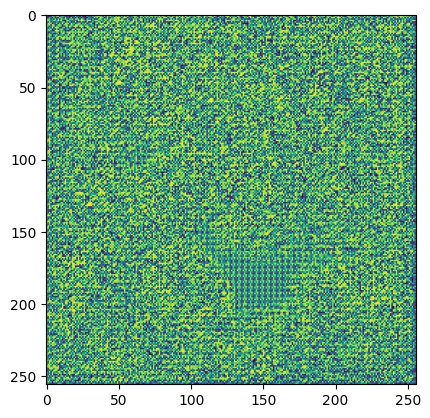

In [22]:
fixed_images = next(iter(test_loader))
reconstruction = generate_samples(fixed_images, model, args)
plt.imshow(reconstruction[0,0].cpu())

In [23]:
do_train = False


if do_train == True: 

    # Generate the samples first once
    fixed_images = next(iter(test_loader))
    #reconstruction = generate_samples(fixed_images, model, args)
    
    best_loss = float('inf')
    for epoch in range(args.num_epochs):
        print(f"Epoch {epoch}/{args.num_epochs}")
        train(train_loader, model, optimizer, args)  # Removed writer
        loss, _ = test(valid_loader, model, args)  # Removed writer
    
        # Generate and save reconstruction images
        reconstruction = generate_samples(fixed_images, model, args)
    
        if epoch % 2 == 0:
            plt.imshow(reconstruction[0,0].cpu() )
            print("reconstruction", reconstruction.shape)

        if epoch % 10 == 0:
            # Save the best model
            if loss < best_loss:
                best_loss = loss
                print(loss)
                with open('revision2_VAE/vqvae_super_resolution_model/best_vq_vae.pt', 'wb') as f:
                    torch.save(model.state_dict(), f)
            
            # Save the model for each epoch
            with open(f'revision2_VAE/vqvae_super_resolution_model/model_vqvae_{epoch + 1}.pt', 'wb') as f:
                torch.save(model.state_dict(), f)

# eval VQ-VAE reconstruction 

In [24]:
model = VectorQuantizedVAE(1, dim=args.hidden_size_vqvae, K=args.k).to(args.device)
checkpoint_path = 'revision2_VAE/vqvae_super_resolution_model/best_vq_vae_l64.pt'  # Path to the saved model
model.load_state_dict(torch.load(checkpoint_path, weights_only=True))

<All keys matched successfully>

In [25]:
hr_era5_gt = next(iter(data.DataLoader(era5_0_25d_256(stage='valid'), batch_size=10, shuffle=False, drop_last=True)))
reconst_hr_era5 = generate_samples(hr_era5_gt, model, args)

hr_era5_gt.shape, reconst_hr_era5.shape

(torch.Size([10, 1, 256, 256]), torch.Size([10, 1, 256, 256]))

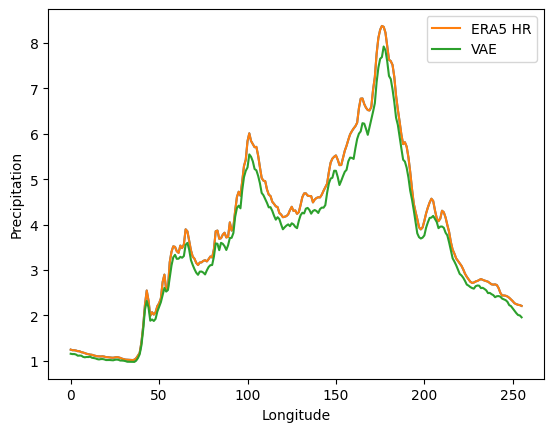

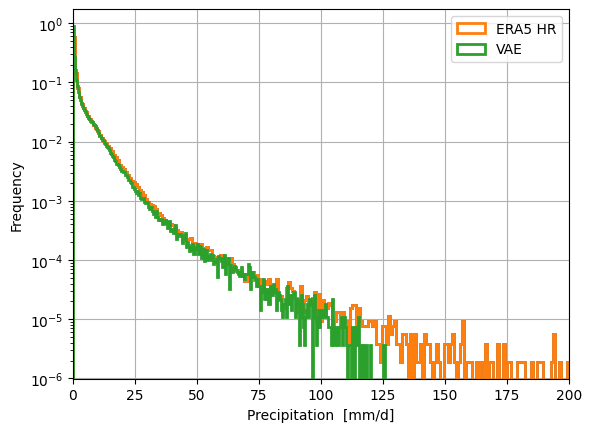

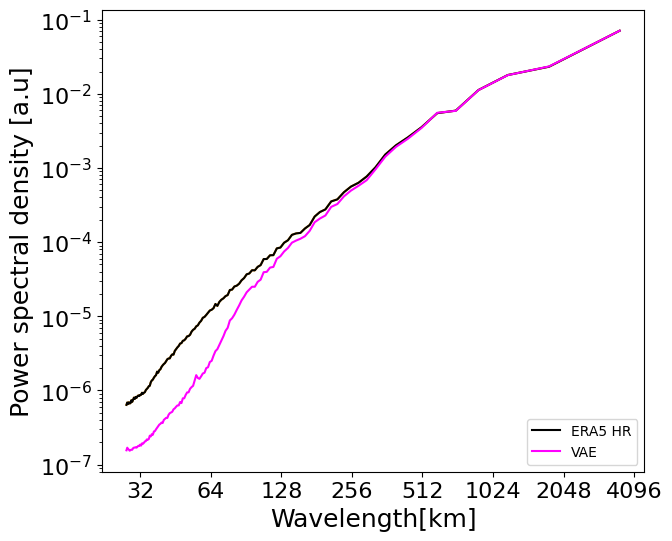

In [26]:
latitudinal_mean_three(train_dataset.inverse_dwd_trafo(hr_era5_gt)
                        ,train_dataset.inverse_dwd_trafo(hr_era5_gt) 
                        ,train_dataset.inverse_dwd_trafo(reconst_hr_era5) 
                        ,label_name=[None, "ERA5 HR", "VAE"] )


histograms_three_np( train_dataset.inverse_dwd_trafo(hr_era5_gt)
                     ,train_dataset.inverse_dwd_trafo(hr_era5_gt)  
                     ,train_dataset.inverse_dwd_trafo(reconst_hr_era5)  .detach().cpu()
                     ,label_name=[None, "ERA5 HR", "VAE"]
                     ,xlim_end=200, bins=300)


ssd = SpatialSpectralDensity_diff_res(
                    train_dataset.inverse_dwd_trafo(hr_era5_gt)  .numpy()  ,
                    train_dataset.inverse_dwd_trafo(hr_era5_gt).cpu()  .numpy()  ,
                    train_dataset.inverse_dwd_trafo(reconst_hr_era5).detach().cpu().numpy(),
                    new_labels=[None, "ERA5 HR", "VAE"]
                )
ssd.run(num_times=None)
ssd.plot_psd(fname="", model_resolution=0.25, model_resolution_2=0.25, plt_legend=True)

reconstruction shape torch.Size([10, 1, 256, 256])


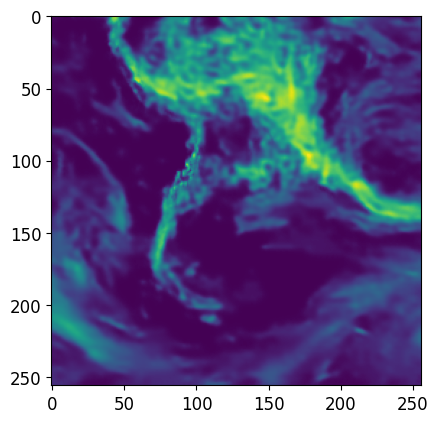

In [27]:
fixed_images = next(iter(test_loader))
reconstruction = generate_samples(fixed_images, model, args)
print("reconstruction shape", reconstruction.shape)
plt.imshow(reconstruction[0,0].cpu())
plt.show()

# check noise lvl

In [28]:
bc_gfdl_dataset_val = QM_GFDL_LR_Dataset_256('data/11_01_deltaQM_debiased_gfdl_valid_custom_dl.pth')
dataloader_bc_gfdl_val = data.DataLoader(bc_gfdl_dataset_val, batch_size=1400, shuffle=False,drop_last=True,num_workers=2)
bc_gfld_sample = next(iter(dataloader_bc_gfdl_val))
print("QM+US - GFDL LR 256 shape:",bc_gfld_sample.shape)

era5_p_1d_256_v = era5_upscaled_1d_256(stage='valid')
dataloader_era5_val_1d_256 = data.DataLoader(era5_p_1d_256_v, batch_size=1400, shuffle=False, drop_last=True)
era5_lr = next(iter(dataloader_era5_val_1d_256))
print(era5_lr.shape)


era5_p025 = era5_0_25d_256(stage='valid')
dataloader_era5_val_p025 = data.DataLoader(era5_p025, batch_size=1400, shuffle=False, drop_last=True)
era5_hr = next(iter(dataloader_era5_val_p025))
print(era5_hr.shape)

datasets size torch.Size([1400, 64, 64])


/dss/dsshome1/0D/ge74xuf2/climate_diffusion/src/dataloader_sr.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.era5_qm = torch.load(self.path).cpu().numpy()


QM+US - GFDL LR 256 shape: torch.Size([1400, 1, 256, 256])
torch.Size([1400, 1, 256, 256])
torch.Size([1400, 1, 256, 256])


x_start.shape torch.Size([1, 1, 256, 256])


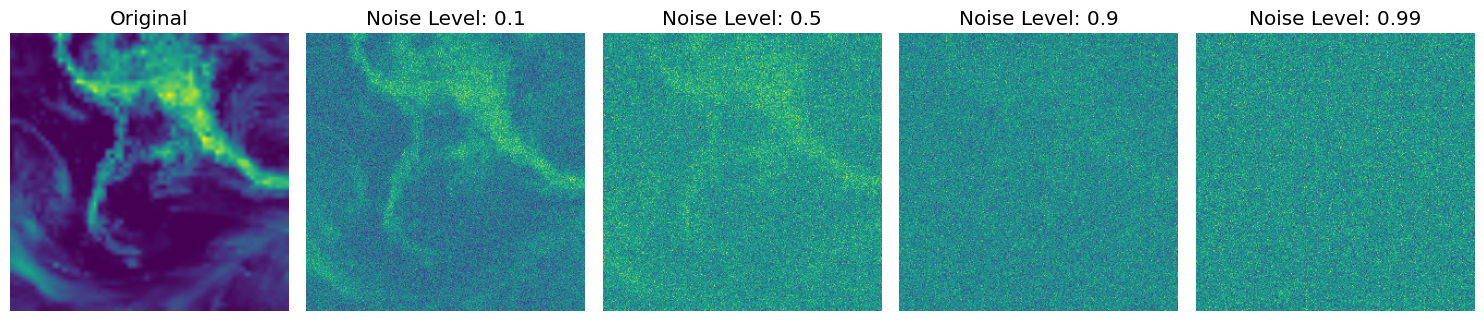

In [29]:
# Function to generate noisy samples
def q_sample(x_start, t, log_snr_fn):
    """Add noise to the image based on the noise level t."""
    dtype = x_start.dtype
    device = x_start.device

    if isinstance(t, float):
        batch = x_start.shape[0]
        t = torch.full((batch,), t, device=device, dtype=dtype)

    noise = torch.randn_like(x_start)
    log_snr = log_snr_fn(t).type(dtype)
    alpha, sigma = log_snr_to_alpha_sigma(log_snr)

    return alpha * x_start + sigma * noise

# Example functions for log SNR and mapping to alpha/sigma
def alpha_cosine_log_snr(t):
    return -torch.log(torch.tan((t + 0.008) * torch.pi / 2))

def log_snr_to_alpha_sigma(log_snr):
    alpha = torch.sqrt(torch.sigmoid(log_snr))
    sigma = torch.sqrt(torch.sigmoid(-log_snr))
    return alpha, sigma

# Load or generate an example image (e.g., single-channel grayscale)
x_start = era5_lr[:1]
print("x_start.shape", x_start.shape)
# Define noise levels to test
noise_levels = [0.1, 0.5, 0.9, 0.99]

# Generate noisy images
noisy_images = [q_sample(x_start, t, alpha_cosine_log_snr) for t in noise_levels]

# Plot the original and noisy images
fig, axes = plt.subplots(1, len(noise_levels) + 1, figsize=(15, 5))

# Plot the original image
axes[0].imshow(x_start[0, 0].cpu())
axes[0].set_title("Original")
axes[0].axis("off")

# Plot noisy images
for i, (t, img) in enumerate(zip(noise_levels, noisy_images)):
    axes[i + 1].imshow(img[0, 0].cpu())
    axes[i + 1].set_title(f"Noise Level: {t}")
    axes[i + 1].axis("off")

plt.tight_layout()
plt.show()

# conditional pixelcnn

In [31]:
# Gated Activation Layer
class GatedActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x, y = x.chunk(2, dim=1)
        return F.tanh(x) * F.sigmoid(y)


# Gated Masked Convolution Layer
class GatedMaskedConv2d(nn.Module):
    def __init__(self, mask_type, dim, kernel, residual=True, conditioning_channels=1):
        super().__init__()
        assert kernel % 2 == 1, print("Kernel size must be odd")
        self.mask_type = mask_type
        self.residual = residual

        # Conditioning image processing (input channels for conditioned image)
        self.conditioning_conv = nn.Conv2d(conditioning_channels, 2 * dim, kernel_size=1)

        # Define kernel shapes and padding
        kernel_shp = (kernel // 2 + 1, kernel)  # (ceil(n/2), n)
        padding_shp = (kernel // 2, kernel // 2)

        # Vertical convolution stack
        self.vert_stack = nn.Conv2d(dim, dim * 2, kernel_shp, 1, padding_shp)

        # To convert vertical to horizontal features
        self.vert_to_horiz = nn.Conv2d(2 * dim, 2 * dim, 1)

        kernel_shp = (1, kernel // 2 + 1)
        padding_shp = (0, kernel // 2)

        # Horizontal convolution stack
        self.horiz_stack = nn.Conv2d(dim, dim * 2, kernel_shp, 1, padding_shp)

        # Residual connection for horizontal
        self.horiz_resid = nn.Conv2d(dim, dim, 1)

        # Gated activation
        self.gate = GatedActivation()

    def make_causal(self):
        # Mask final row and column for causality
        self.vert_stack.weight.data[:, :, -1].zero_()
        self.horiz_stack.weight.data[:, :, :, -1].zero_()

    def forward(self, x_v, x_h, conditioning_image):
        if self.mask_type == 'A':
            self.make_causal()

        # Process conditioning image through 1x1 convolution
        h_cond = self.conditioning_conv(conditioning_image)

        # Process vertical stack with conditioning image
        h_vert = self.vert_stack(x_v)
        h_vert = h_vert[:, :, :x_v.size(-1), :]
        out_v = self.gate(h_vert + h_cond)

        # Process horizontal stack with conditioning image
        h_horiz = self.horiz_stack(x_h)
        h_horiz = h_horiz[:, :, :, :x_h.size(-2)]
        v2h = self.vert_to_horiz(h_vert)

        out = self.gate(v2h + h_horiz + h_cond)
        if self.residual:
            out_h = self.horiz_resid(out) + x_h
        else:
            out_h = self.horiz_resid(out)

        return out_v, out_h


# Gated PixelCNN Model
class GatedPixelCNN(nn.Module):
    def __init__(self, input_dim=256, dim=64, n_layers=15, conditioning_channels=1):
        super().__init__()
        self.dim = dim

        # Create embedding layer to embed input (latent space)
        self.embedding = nn.Embedding(input_dim, dim)

        # Building the PixelCNN layers
        self.layers = nn.ModuleList()

        for i in range(n_layers):
            mask_type = 'A' if i == 0 else 'B'
            kernel = 7 if i == 0 else 3
            residual = False if i == 0 else True

            self.layers.append(
                GatedMaskedConv2d(mask_type, dim, kernel, residual, conditioning_channels)
            )

        # Add output convolution layer
        self.output_conv = nn.Sequential(
            nn.Conv2d(dim, 512, 1),
            nn.ReLU(True),
            nn.Conv2d(512, input_dim, 1)
        )

    def forward(self, x, conditioning_image):
        # Embed the input latent codes
        shp = x.size() + (-1, )
        x = self.embedding(x.view(-1)).view(shp)  # (B, H, W, C)
        x = x.permute(0, 3, 1, 2)  # (B, C, W, W)

        # Split input for vertical and horizontal processing
        x_v, x_h = (x, x)
        for layer in self.layers:
            x_v, x_h = layer(x_v, x_h, conditioning_image)

        return self.output_conv(x_h)

    def generate(self, conditioning_image, shape=(8, 8), batch_size=64):
        param = next(self.parameters())
        x = torch.zeros(
            (batch_size, *shape),
            dtype=torch.int64, device=param.device
        )

        for i in range(shape[0]):
            for j in range(shape[1]):
                logits = self.forward(x, conditioning_image)
                probs = F.softmax(logits[:, :, i, j], -1)
                x.data[:, i, j].copy_(
                    probs.multinomial(1).squeeze().data
                )
        return x


# Train PixelCNN

In [32]:
# Define a mock argument class for the notebook context
class Args:
    def __init__(self):
        self.hidden_size_vqvae = 64 #256
        self.hidden_size_prior = 64
        self.k = 512
        self.num_layers = 15
        self.num_epochs = 500
        self.lr = 3e-4
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.steps = 0

args = Args()

In [33]:
# Initialize model, optimizer, and Tensorboard writer
model = VectorQuantizedVAE(1, dim=args.hidden_size_vqvae, K=args.k).to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

In [34]:
model = VectorQuantizedVAE(1, dim=args.hidden_size_vqvae, K=args.k).to(args.device)
checkpoint_path = 'revision2_VAE/vqvae_super_resolution_model/best_vq_vae_l64.pt'  # Path to the saved model
model.load_state_dict(torch.load(checkpoint_path, weights_only=True) )
model.eval()
"vq-vae weights loaded"

'vq-vae weights loaded'

In [35]:
# Dummy input
dummy_input = torch.randn(10, 1, 256, 256).to(args.device)  # Batch size of 1, single channel, 64x64 input

# Pass through the encoder
encoded_output = model.encoder(dummy_input)
print(encoded_output.shape)

encode_output = model.encode(dummy_input)
print(encode_output.shape)

torch.Size([10, 64, 64, 64])
torch.Size([10, 64, 64])


In [36]:
# Initialize the PixelCNN prior (conditional on lower-res image)
prior = GatedPixelCNN(input_dim=args.k,  # Set input_dim as k (number of latent vectors)
                      dim=args.hidden_size_prior, 
                      n_layers=args.num_layers,
                      conditioning_channels=1).to(args.device)  # Conditioning on 1-channel LR ERA5 images

# Optimizer
optimizer = torch.optim.Adam(prior.parameters(), lr=args.lr)

In [37]:
# Loss function for training the conditional PixelCNN prior
def train(data_loader, model, prior, optimizer, args):
    for images, images_lr in data_loader:  # Assuming labels are not used for training in this case
        images = images.to(args.device)
        images_lr = images_lr[:, :, ::4, ::4]
        images_lr,_ ,_ ,_  = imagen.noise_schedulers.q_sample(images_lr.to("cpu"),torch.tensor(0.1))
        images_lr = images_lr.clip(-1,1)
        images_lr = images_lr.to(args.device)
        
    
        
        # Get latents from VAE encoder
        with torch.no_grad():
            latents = model.encode(images)
            latents = latents.detach()

        # Compute logits using the PixelCNN prior, conditioned on lower-resolution image (lr_era5)
        logits = prior(latents, images_lr)  # Use lr_era5 image as input to the prior model
        logits = logits.permute(0, 2, 3, 1).contiguous()  # Reorganize logits for cross-entropy

        optimizer.zero_grad()
        # Cross-entropy loss between logits and latent codes
        loss = F.cross_entropy(logits.view(-1, args.k), latents.view(-1))
        loss.backward()

        optimizer.step()
        args.steps += 1

# Testing function for the conditional PixelCNN prior
def test(data_loader, model, prior, args):
    with torch.no_grad():
        total_loss = 0.
        num_batches = 0  # Counter for batches
        for images, images_lr in data_loader:  # Assuming labels are not used for testing
            images = images.to(args.device)
            
            images_lr,_ ,_ ,_  = imagen.noise_schedulers.q_sample(images_lr.to("cpu"),torch.tensor(0.1))
            images_lr = images_lr.clip(-1,1)
            images_lr = images_lr.to(args.device)[:, :, ::4, ::4]

            latents = model.encode(images)
            latents = latents.detach()

            logits = prior(latents, images_lr)  # Use lr_era5 image as input to the prior model
            logits = logits.permute(0, 2, 3, 1).contiguous()  # Reorganize logits for cross-entropy

            total_loss += F.cross_entropy(logits.view(-1, args.k), latents.view(-1))
            num_batches += 1  # Increment batch counter

        # Calculate average loss
        avg_loss = total_loss / num_batches if num_batches > 0 else 0.0
        return avg_loss.item()


In [38]:
do_train_cond_prior = False

if do_train_cond_prior == True:
    # Main training loop
    best_loss = float('inf')
    for epoch in range(1, args.num_epochs + 1):
        # Train for one epoch
        print(f"Epoch {epoch}/{args.num_epochs}")
        train(data_loader=zip(train_loader, train_loader_lr), model=model, prior=prior, optimizer=optimizer, args=args)

        # Evaluate on validation set
        loss = test(data_loader=zip(test_loader, test_loader_lr), model=model, prior=prior, args=args)

        # Save the model every 5 epochs
        if epoch % 50 == 0:
            model_path = f'revision2_VAE/vqvae_super_resolution_model/epoch_{epoch}_prior_conditional_noise.pt'
            torch.save(prior.state_dict(), model_path)
            print(f'Saved model at epoch {epoch} with loss: {loss}')

            # Save the model if the validation loss improves
            if loss < best_loss:
                best_loss = loss
                model_path = f'revision2_VAE/vqvae_super_resolution_model/best_prior_conditional_noise_epoch_{epoch}.pt'
                torch.save(prior.state_dict(), model_path)
                print(f'Saved best model at epoch {epoch} with loss: {best_loss}')
    
    print(f'Training complete! Best validation loss: {best_loss}')

# Downscaling with VQ-VAE

In [39]:
def infer(prior, vqvae, lr_condition, shape=(16, 16), device='cuda'):
    """
    Perform inference to generate high-resolution images using the PixelCNN prior and VQ-VAE decoder.
    
    Args:
        prior: Trained PixelCNN prior model.
        vqvae: Trained VQ-VAE model.
        lr_condition: Low-resolution conditioning image (lr_era5).
        shape: Shape of the latent space to generate (height, width).
        device: Device to run inference ('cuda' or 'cpu').

    Returns:
        HR_images: Generated high-resolution images.
    """
    prior.eval()  # Set prior to evaluation mode
    vqvae.eval()  # Set VQ-VAE to evaluation mode

    # Move low-resolution conditioning image to device

    lr_condition,_ ,_ ,_  = imagen.noise_schedulers.q_sample(lr_condition.to("cpu"),torch.tensor(0.1))
    lr_condition = lr_condition.clip(-1,1)
    lr_condition = lr_condition[:, :, ::4, ::4].to(device)


    # Initialize latent indices tensor with zeros
    batch_size = lr_condition.size(0)
    latent_indices = torch.zeros((batch_size, *shape), dtype=torch.int64, device=device)

    # Autoregressively generate latent indices
    for i in range(shape[0]):
        for j in range(shape[1]):
            logits = prior(latent_indices, lr_condition)
            probs = F.softmax(logits[:, :, i, j], dim=-1)  # Convert logits to probabilities
            latent_indices[:, i, j] = probs.multinomial(1).squeeze(-1)  # Sample from probabilities

    # Decode latent indices to high-resolution images
    HR_images = vqvae.decode(latent_indices)

    return HR_images

In [40]:
prior.load_state_dict(torch.load("revision2_VAE/vqvae_super_resolution_model/epoch_200_prior_conditional_noise.pt", weights_only=True))
prior.to(args.device)
prior.eval()

test_texample = False

if test_texample == True:
    # Example low-resolution input
    lr_condition = next(iter(test_loader_lr)).to(args.device)  # Batch of 4 low-res images (1 channel, 64x64)
    
    shape = (64, 64)  # Shape of latent space (depends on VQ-VAE encoder output spatial resolution)
    HR_images = infer(prior=prior, vqvae=model, lr_condition=lr_condition, shape=shape, device=args.device)
    
    HR_images = HR_images.detach().cpu()
    # HR_images will have the shape (batch_size, channels, height, width)
    print("Generated HR images shape:", HR_images.shape)

In [41]:
if test_texample == True:
    print("LR conditions")
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))  
    for i in range(10):
        row, col = divmod(i, 5)  
        axes[row, col].imshow(lr_condition.detach().cpu()[i].permute(1, 2, 0).numpy())
        axes[row, col].axis('off')
    plt.tight_layout()  
    plt.show()

In [42]:
if test_texample == True:
    print("HR VQ-VAE-pixelCNN generated samples")
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))  
    for i in range(10):
        row, col = divmod(i, 5)  
        axes[row, col].imshow(HR_images.detach().cpu()[i].permute(1, 2, 0).numpy())
        axes[row, col].axis('off')
    plt.tight_layout()  
    plt.show()

In [43]:
if test_texample == True:
    hr_gt = next(iter(test_loader))
    
    print("HR Ground truth")
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))  
    for i in range(10):
        row, col = divmod(i, 5)  
        axes[row, col].imshow(hr_gt.detach().cpu()[i].permute(1, 2, 0).numpy())
        axes[row, col].axis('off')
    plt.tight_layout()  
    plt.show()

In [44]:
if test_texample == True:
    latitudinal_mean_three(train_dataset.inverse_dwd_trafo(hr_gt)
                            ,train_dataset.inverse_dwd_trafo(lr_condition) 
                            ,train_dataset.inverse_dwd_trafo(HR_images) 
                            ,label_name=["ERA5 HR", "ERA5 LR", "VAE"] )
    
    
    histograms_three_np( train_dataset.inverse_dwd_trafo(hr_gt)
                         ,train_dataset.inverse_dwd_trafo(lr_condition)  .cpu()
                         ,train_dataset.inverse_dwd_trafo(HR_images)  
                         ,label_name=["ERA5 HR", "ERA5 LR", "VAE"]
                         ,xlim_end=200, bins=300)
    
    
    ssd = SpatialSpectralDensity_diff_res(
                        train_dataset.inverse_dwd_trafo(hr_gt)  .numpy()  ,
                        train_dataset.inverse_dwd_trafo(lr_condition).cpu()  .numpy()  ,
                        train_dataset.inverse_dwd_trafo(HR_images).numpy(),
                        new_labels=["ERA5 HR", "ERA5 LR", "VAE"]
                    )
    ssd.run(num_times=None)
    ssd.plot_psd(fname="", model_resolution=0.25, model_resolution_2=0.25, plt_legend=True)

# do inference on validation set

In [45]:
do_eval_whole_valid_ds_vqvae = False

if do_eval_whole_valid_ds_vqvae == True:
    # List to store the resulting HR images
    all_HR_images = []
    
    # Iterate over the test_loader_lr dataset
    for lr_condition in test_loader_lr:
        lr_condition = lr_condition.to(args.device)  # Move batch to device
        
        #print("lr_condition.shape", lr_condition.shape)
        
        # Apply inference
        HR_images = infer(prior=prior, vqvae=model, lr_condition=lr_condition, shape=shape, device=args.device)
    
        # Detach and move the result back to CPU
        HR_images = HR_images.detach().cpu()
    
        # Append the HR images to the list
        all_HR_images.append(HR_images)
    
    # Concatenate all HR images along the batch dimension
    all_HR_images = torch.cat(all_HR_images, dim=0)
    
    # Save the resulting tensor to the specified file
    #torch.save(all_HR_images, "revision2_VAE/vqvae_super_resolution_model/vqvae_era5_valid_downscaled.pt")
    
    # Print the shape of the final HR images tensor
    print("Generated HR images shape:", all_HR_images.shape)

In [46]:
vqvae_hr_valid = torch.load("revision2_VAE/vqvae_super_resolution_model/vqvae_era5_valid_downscaled.pt", weights_only=True)
vqvae_hr_valid.shape

torch.Size([1430, 1, 256, 256])

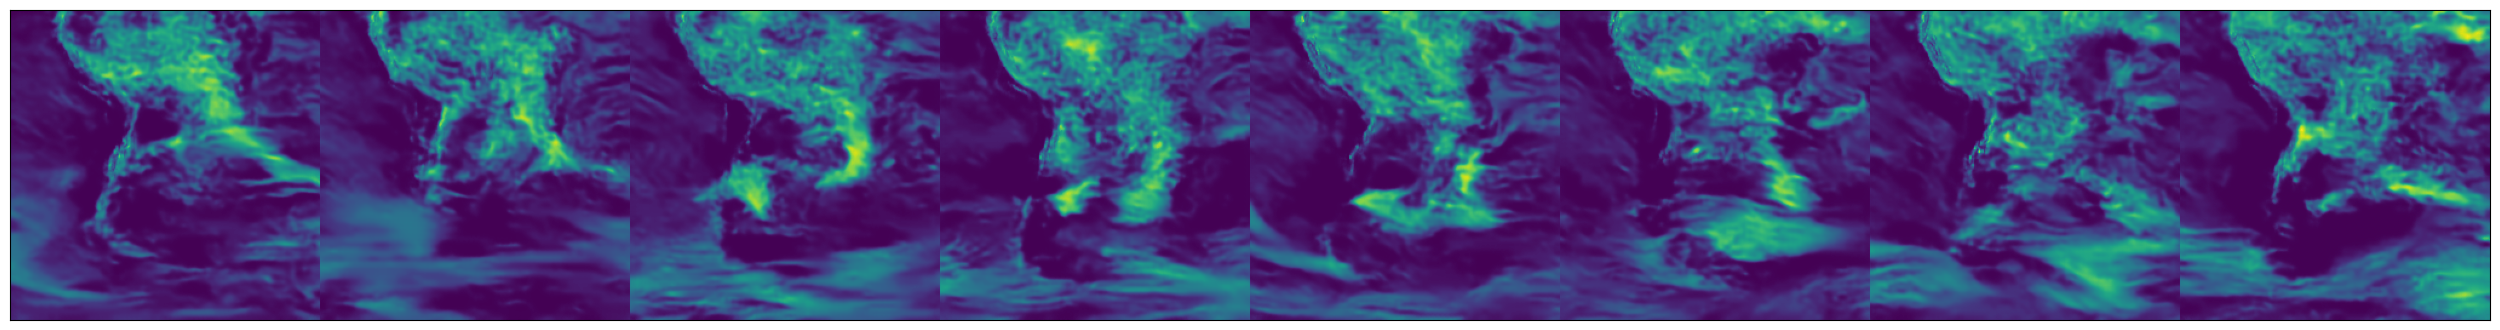

In [47]:
plot_images_no_lab(vqvae_hr_valid[:8])

In [48]:
test_dataset = era5_0_25d_256(stage='valid')
test_loader = data.DataLoader(test_dataset, batch_size=1430, shuffle=False, drop_last=True)
era5_hr_val = next(iter(test_loader))
print("HR ERA5 val", era5_hr_val.shape)

HR ERA5 val torch.Size([1430, 1, 256, 256])


In [49]:
test_dataset_lr = era5_upscaled_1d_256(stage='valid')
test_loader_lr = data.DataLoader(test_dataset_lr, batch_size=1430, shuffle=False, drop_last=True)
era5_lr_val = next(iter(test_loader_lr))
print("LR ERA5 valid", next(iter(test_loader_lr)).shape)

LR ERA5 valid torch.Size([1430, 1, 256, 256])


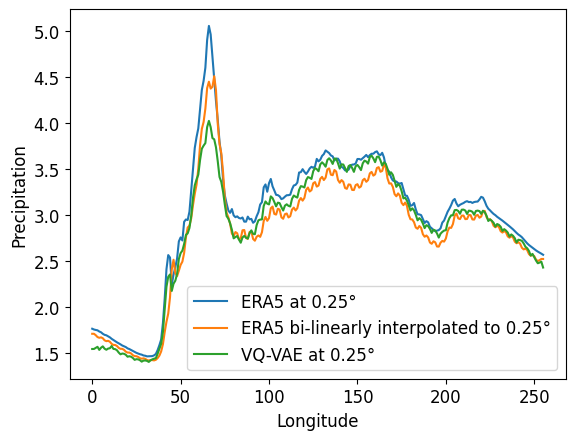

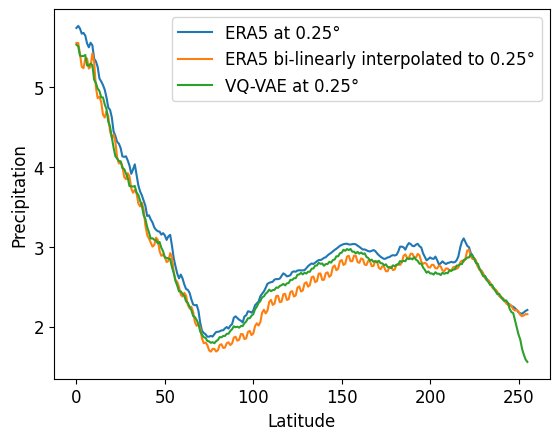

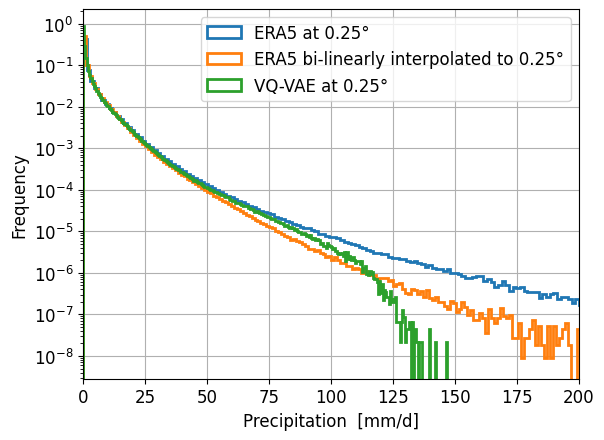

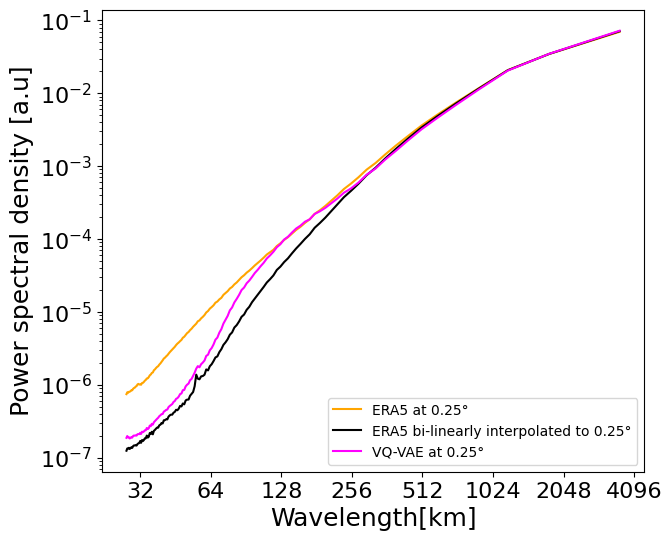

In [50]:
latitudinal_mean_three(test_dataset.inverse_dwd_trafo(era5_hr_val)
                        ,test_dataset_lr.inverse_dwd_trafo(era5_lr_val) 
                        ,test_dataset.inverse_dwd_trafo(vqvae_hr_valid) 
                        ,label_name=["ERA5 at 0.25°", "ERA5 bi-linearly interpolated to 0.25°", "VQ-VAE at 0.25°"] )


longitudinal_mean_three(test_dataset.inverse_dwd_trafo(era5_hr_val)
                        ,test_dataset_lr.inverse_dwd_trafo(era5_lr_val) 
                        ,test_dataset.inverse_dwd_trafo(vqvae_hr_valid) 
                        ,label_name=["ERA5 at 0.25°", "ERA5 bi-linearly interpolated to 0.25°", "VQ-VAE at 0.25°"] )


histograms_three_np( test_dataset.inverse_dwd_trafo(era5_hr_val)
                     ,test_dataset_lr.inverse_dwd_trafo(era5_lr_val)  .cpu()
                     ,test_dataset.inverse_dwd_trafo(vqvae_hr_valid)  
                     ,label_name=["ERA5 at 0.25°", "ERA5 bi-linearly interpolated to 0.25°", "VQ-VAE at 0.25°"]
                     ,xlim_end=200, bins=300)


ssd = SpatialSpectralDensity_diff_res(
                    test_dataset.inverse_dwd_trafo(era5_hr_val)  .numpy()  ,
                    test_dataset_lr.inverse_dwd_trafo(era5_lr_val).cpu()  .numpy()  ,
                    test_dataset.inverse_dwd_trafo(vqvae_hr_valid).numpy(),
                    new_labels=["ERA5 at 0.25°", "ERA5 bi-linearly interpolated to 0.25°", "VQ-VAE at 0.25°"]
                )
ssd.run(num_times=None)
ssd.plot_psd(fname="", model_resolution=0.25, model_resolution_2=0.25, plt_legend=True)

# generate an ensemble

In [51]:
era5_p_1d_256_v = era5_upscaled_1d_256(stage='valid')

dataloader_era5_val_1d_256 = data.DataLoader(era5_p_1d_256_v, batch_size=bs_valid, shuffle=False, drop_last=True,
                                     num_workers=wandb.config.num_workers)

era5_lr_v = next(iter(dataloader_era5_val_1d_256))
print(era5_lr_v.shape)

torch.Size([10, 1, 256, 256])


In [ ]:
vqvae_hr_valid = torch.load("revision2_VAE/vqvae_super_resolution_model/vqvae_era5_valid_downscaled.pt", weights_only=True)
vqvae_hr_valid.shape

prior.load_state_dict(torch.load("revision2_VAE/vqvae_super_resolution_model/epoch_200_prior_conditional_noise.pt", weights_only=True))
prior.to(args.device)
prior.eval()

In [ ]:
do_generate_ensemble_1y_s50 = True

if do_generate_ensemble_1y_s50 == True:
    from torch.utils.data import DataLoader, Subset
    import os
    import torch

    # Define the subset of the dataset (first 365 days)
    era5_p_1d_256_v_subset = Subset(era5_p_1d_256_v, range(365))
    
    # Define the DataLoader with the subset and batch size of 5
    dl_365d_era5_lr = DataLoader(era5_p_1d_256_v_subset, batch_size=5, shuffle=False, drop_last=True, num_workers=wandb.config.num_workers)
    
    # Folder to save ensemble results
    save_folder = "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_vq_vae_ensemble"
    os.makedirs(save_folder, exist_ok=True)
    
    # Perform 50 ensemble runs
    ensemble_outputs = []  # Store all ensemble outputs for spread comparison
    for i in range(1, 51):
        print(f"Starting ensemble run {i}...")
        output_tensors = []
    
        for b, el in enumerate(dl_365d_era5_lr):
            print(f"  Processing batch {b+1}...")
            # Move input batch to CPU and sample with noise scheduler
            era5_lr_batch = el.to("cuda").float()
            
            # Apply the VQ-VAE/PixelCNN model to restore the data
            HR_images = infer(prior=prior, vqvae=model, lr_condition=era5_lr_batch, shape=(64, 64), device="cuda")
            output_tensors.append(HR_images.cpu())
    
        # Concatenate all output tensors into one dataset
        sr_era5_dataset = torch.cat(output_tensors, dim=0)
        ensemble_outputs.append(sr_era5_dataset)  # Add this to the ensemble list
        
        # Save the current ensemble output
        save_path = os.path.join(save_folder, f"ensemble_{i + 13}.pt")
        torch.save(sr_era5_dataset, save_path)
        print(f"  Saved ensemble run {i} to {save_path}")
    
    print("All ensemble runs completed. Now calculating spread...")

In [ ]:
save_folder = "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_vq_vae_ensemble"

# Initialize a list to store the loaded ensemble runs
ensemble_outputs2 = []

# Load all ensemble runs from the folder
for i in range(1, 51):  # Assuming you have 50 ensemble runs saved as ensemble_1.pt, ensemble_2.pt, ...
    file_path = os.path.join(save_folder, f"ensemble_{i}.pt")
    
    if os.path.exists(file_path):
        print(f"Loading {file_path}...")
        ensemble_run = torch.load(file_path, weights_only=True)  # Load the saved tensor
        print("trafo units here")
        ensemble_run = test_dataset.inverse_dwd_trafo(ensemble_run)
        ensemble_outputs2.append(ensemble_run)
    else:
        print(f"File {file_path} does not exist.")

# After loading all ensemble runs, stack them along a new dimension (dim=0)
ensemble_stack = torch.stack(ensemble_outputs2, dim=0)  # Shape: (50, 365*256*256 or so, ...)

# Now you can proceed with the further analysis or visualization
print(f"Ensemble stack shape: {ensemble_stack.shape}")